In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
filepath = './data/f1_data_processed.csv'

In [16]:
def data_loader(filepath, columns_to_include, categorical_cols):
    """
    Load and preprocess the dataset by selecting specific columns and drop missing values

    Parameters:
    filepath (str): The path to the CSV file
    columns_to_include (list): List of columns to include in the output data

    Returns:
    pd.DataFrame: loaded DataFrame.
    """
    # load the dataset
    df = pd.read_csv(filepath)

    # select the specific columns
    df = df[columns_to_include]

    # drop na values
    df.dropna(inplace=True)

    # Apply one-hot encoding to categorical variables
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

In [17]:
def split_data(df, target_column):
    """
    Split the data into training and testing sets

    Parameters:
    df (pd.DataFrame): The preprocessed DataFrame
    target_column (str): The name of the y column

    Returns:
    tuple: X_train, X_test, y_train, y_test
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the test set

    Parameters:
    model: Trained model
    X_test (pd.DataFrame): Test features
    y_test (pd.Series): Test target

    Returns:
    None
    """
    predictions = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("\nClassification Report:\n", classification_report(y_test, predictions))

### Training Preparation

In [51]:
# Define the columns to include in the dataset
columns_to_include = ['DriverId', 'TeamId', 'GridPosition', 'Year', 
                      'Position_Qual', 'AirTemp', 'Humidity', 'Pressure', 
                      'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed', 
                      'RaceName', 'Finished']
categorical_cols = ['DriverId', 'TeamId', 'RaceName', 'Year']

df = data_loader(filepath, columns_to_include, categorical_cols)

# Split the data
X_train, X_test, y_train, y_test = split_data(df, 'Finished')

### Model Selection

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [53]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Neural Network": MLPClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

Logistic Regression: 0.8428 (+/- 0.0017)
Random Forest: 0.8511 (+/- 0.0083)
SVM: 0.8355 (+/- 0.0054)
XGBoost: 0.8263 (+/- 0.0190)
KNN: 0.8346 (+/- 0.0157)
Neural Network: 0.8235 (+/- 0.0385)
Decision Tree: 0.7482 (+/- 0.0142)


### Logistic Regression 

In [54]:
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train, y_train)

# Get the coefficients and feature names
coefficients = model_lr.coef_[0]
features = X_train.columns

# Create a DataFrame to view the coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df['AbsCoefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Display the feature importance
print(coef_df[['Feature', 'Coefficient']].head(5))

                          Feature  Coefficient
17              DriverId_hamilton     1.049619
83     RaceName_Tuscan Grand Prix    -1.029140
68  RaceName_Hungarian Grand Prix     0.978964
29                 DriverId_perez     0.911687
5                        Rainfall    -0.879075


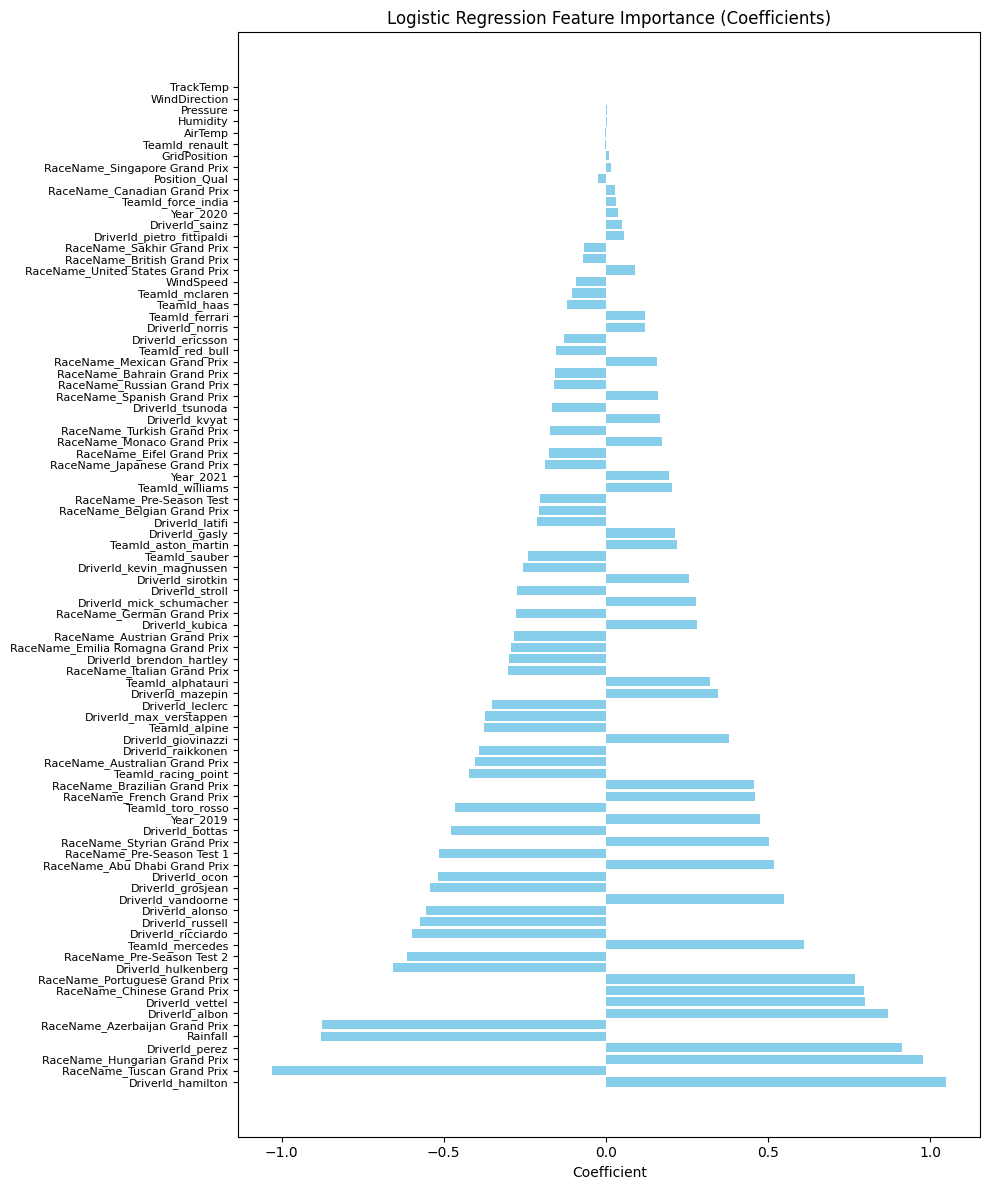

In [55]:
plt.figure(figsize=(10, 12))  # Increase figure size
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Feature Importance (Coefficients)')

# Adjusting font size for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()  # Adjust layout to prevent clipping

plt.show()

In [56]:
evaluate_model(model_lr, X_test, y_test)

Accuracy: 0.8455882352941176

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.85      1.00      0.92       230

    accuracy                           0.85       272
   macro avg       0.42      0.50      0.46       272
weighted avg       0.72      0.85      0.77       272



### Random Forest

In [57]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Get the feature importances and feature names
importances = model_rf.feature_importances_
features = X_train.columns

# Create a DataFrame to view the feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(5))

         Feature  Importance
1  Position_Qual    0.103427
0   GridPosition    0.100577
2        AirTemp    0.049348
7  WindDirection    0.047114
6      TrackTemp    0.046510


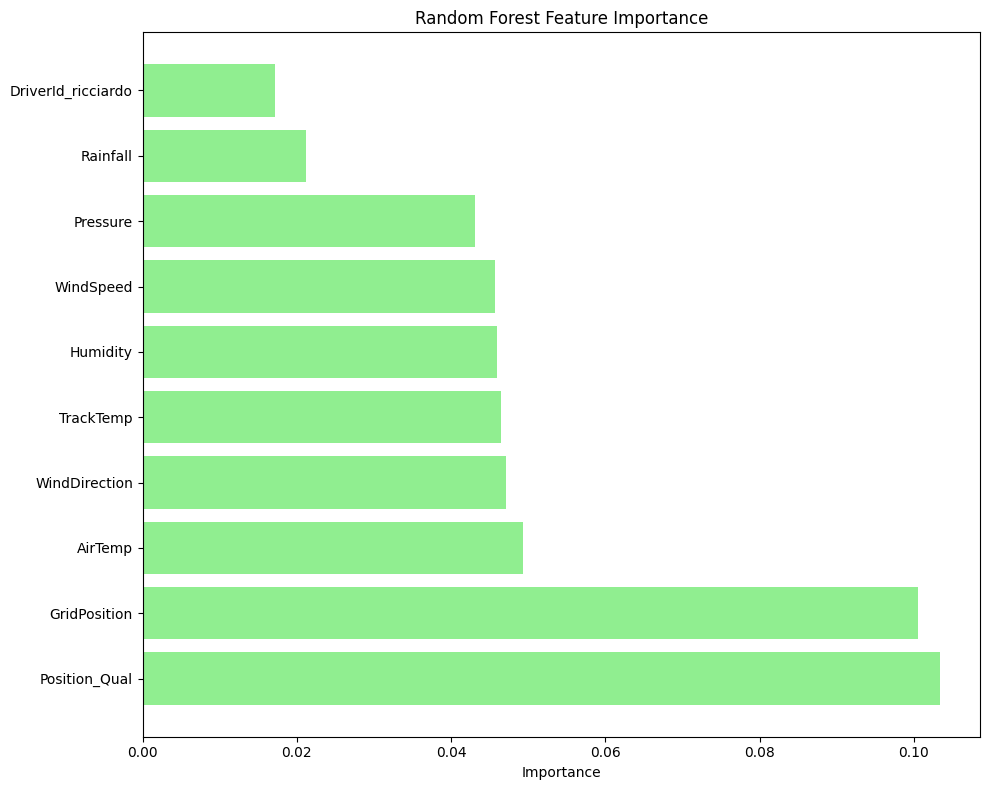

In [58]:
# plot the top 10 important features
plot_df = importance_df.head(10)

plt.figure(figsize=(10, 8))  # Increase figure size
plt.barh(plot_df['Feature'], plot_df['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')

# Adjusting font size for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout to prevent clipping

plt.show()

In [59]:
evaluate_model(model_rf, X_test, y_test)

Accuracy: 0.8566176470588235

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.10      0.17        42
           1       0.86      1.00      0.92       230

    accuracy                           0.86       272
   macro avg       0.83      0.55      0.55       272
weighted avg       0.85      0.86      0.81       272

